In [1]:
#Importing necessary packages

import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
try:
    import matplotlib.pyplot as plt
except:
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt


class PolynomialRegression():
    def __init__(self, degree):
        """
        Implement polynomial regression from scratch.
        
        This class takes as input "degree", which is the degree of the polynomial 
        used to fit the data. For example, degree = 2 would fit a polynomial of the 
        form:

            ax^2 + bx + c
        
    
        https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html
        https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
        http://interactiveaudiolab.github.io/teaching/eecs349stuff/eecs349_linear_regression.pdf
    
      
        Usage:
            import numpy as np
            
            x = np.random.random(100)
            y = np.random.random(100)
            learner = PolynomialRegression(degree = 1)
            learner.fit(x, y) # this should be pretty much a flat line
            predicted = learner.predict(x)

            new_data = np.random.random(100) + 10
            predicted = learner.predict(new_data)
            # confidence compares the given data with the training data
            confidence = learner.confidence(new_data)

        Args:
            degree (int): Degree of polynomial used to fit the data.
        """
        self.degree = degree
        self.features = None
        self.targets = None
        self.training_data = None
        self.weights = None
        self.polynomial = None

    def fit(self, features, targets):
        """
        Fit the given data using a polynomial. The degree is given by self.degree,
        which is set in the __init__ function of this class. 
        
        Args:
            features (np.ndarray): 1D array containing real-valued inputs.
            targets (np.ndarray): 1D array containing real-valued targets.
        Returns:
            None (saves model and training data internally)
        """
        self.features = features
        self.targets = targets
        self.training_data = np.array([[feature**deg for deg in range(self.degree + 1)] for feature in self.features])
        transposed = self.training_data.transpose()
        inverse_matrix = self.invert(np.matmul(transposed, self.training_data))
        transposed_matrix = np.matmul(inverse_matrix, transposed)
        self.weights = np.matmul(transposed_matrix, targets)
        self.polynomial = np.poly1d(self.weights[::-1])

    def invert(self, matrix):
        rank = np.linalg.matrix_rank(matrix)
        if matrix.shape[0] == matrix.shape[1] and matrix.shape[0] == rank:
            return np.linalg.inv(matrix)
        else:
            self.training_data = np.array([feature + np.random.normal(0, .0000000000000000001, self.degree + 1) for feature in self.training_data])
            transposed = self.training_data.transpose()
            return np.linalg.inv(np.matmul(transposed, self.training_data))

    def predict(self, features):
        """
        Args:
            features (np.ndarray): 1D array containing real-valued inputs.
        Returns:
            predictions (np.ndarray): Output of saved model on features.
        """
        return np.array([self.polynomial(feature) for feature in features])

    def frange(self, start, stop, step):
        val = start
        while val < stop:
            yield val
            val += step

    def visualize(self, features, targets):
        """
        This function produces a single plot containing a scatter plot of the
        features and the targets, and the polynomial fit by the model is
        graphed on top of the points.

        Args:
            features (np.ndarray): 1D array containing real-valued inputs.
            targets (np.ndarray): 1D array containing real-valued targets.
        Returns:
            None (plots to the active figure)
        """
        plt.scatter(features, targets, c='b')
        x = list(self.frange(features.min(), features.max(), .01))
        y = self.polynomial(x)
        plt.plot(x, y, c='r')
        plt.xlabel("% Students on Support Program")
        plt.ylabel("% AP Students")
        plt.title("Relationship between Student SES and AP Prevalence")
        plt.show()

#Reading in the xls files
df_students = pd.read_excel(io = "AP Students.xls", sheet_name = "AP Students")
df_students.set_index("School ID", inplace=True)

df_exams = pd.read_excel(io = "AP Exams.xls")
df_exams.set_index("School ID", inplace=True)

df_demographics = pd.read_excel(io = "Demographics.xls", sheet_name="Schools")
df_demographics.set_index("School ID", inplace=True)

df_metrics = pd.read_excel(io = "Metrics.xls")
df_metrics.set_index("School ID", inplace=True)

#Dictionary with key being the school id and the values being AP Student % and Score of 3 or above respectfully
examples = {id_num:[] for id_num in df_metrics.index}

#Reading in the percentage of AP Students vs Total
for id_number in examples.keys():
    if id_number in df_students.index:
        number_exams = df_students.loc[id_number]["Number of AP Students"]
        number_students = df_demographics.loc[id_number]["Total"]
        examples[id_number].append(number_exams / number_students)
        percentage = df_students.loc[id_number]["Percent of AP Students with a Score of 3 or Higher"]
        examples[id_number].append(percentage)
        support_program = df_demographics.loc[id_number]["%"]
        examples[id_number].append(df_demographics.loc[id_number]["%"])
        examples[id_number].append((df_metrics.loc[id_number]["Enrollments"] / (number_students / 4)) * 100)
    if id_number in df_metrics.index:
        if len(examples[id_number]) != 0:
            examples[id_number].append(df_metrics.loc[id_number]["Enrollment Pct"])

# Cleaning data: removing empty attribute keys
# New format looks this
# Key : [% of AP students, % Percent of AP Students with a Score of 3 or Higher, % of Students on Support Program, , Enrollment Pct Normalized, Enrollment Pct]
cleaned_examples = {key: value for key, value in examples.items() if len(value) != 0 and value[1] != "*"}

def test_regressions(inputs, degree = 1):
    '''
    If you have more than one input ---> multivariate regression
    If you have only one input ---> Polynomial Regression, you can choose the degree
    '''
    y = np.array([value[3] for key, value in cleaned_examples.items()])
    if len(inputs) > 1:
        x = np.array([[value[i] for i in inputs] for key, value in cleaned_examples.items()])
        poly = PolynomialFeatures(degree = 1)
        x_transformed = poly.fit_transform(x)
        
        regression = LinearRegression()
        regression.fit(x_transformed, y)
        predictions = regression.predict(x_transformed)
        mse = mean_squared_error(y, predictions)
        r_square = r2_score(y, predictions)
        return r_square
    else:
        x = np.array([value[inputs[0]] for key, value in cleaned_examples.items()])
        reg = PolynomialRegression(degree = degree)
        reg.fit(x,y)
        reg.visualize(x,y)
        predictions = reg.predict(x)
        r_square = r2_score(y, predictions)
        return r_square

inputs = [0]
test_regressions(inputs, 1)



<Figure size 640x480 with 1 Axes>

0.44170735000953254

In [2]:
cleaned_examples[610402]

[0.5918367346938775, 34.5, 0.6888, 177.55102040816325, 87]

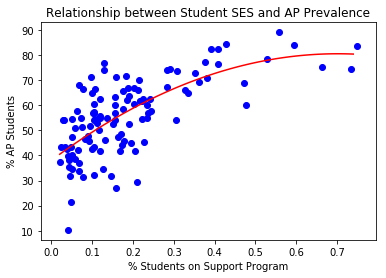

0.48255256392119783

In [3]:
del cleaned_examples[610402]
inputs = [0]
test_regressions(inputs, 2)